# Decision Tree and RandomForest Classifier

### Target2: 10% increase in 5 days

In [1]:
import pandas as pd
import numpy as np
import time, datetime
import math
import matplotlib.pyplot as plt

### Gather data and create features

In [2]:
import pandas_datareader as web

C:\Users\Eddie\Anaconda3\envs\tensorflow\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
tickers = ['VBIV', 'AGRX', 'VXRT', 'JAGX', 'MNKD', 'OPK', 'IMGN']

In [4]:
today = datetime.date.today()
start_date = '2018-01-01'
end_date = today

In [5]:
#The following function loads the data for each ticker and creates the features and target variables
#For more information about each feature see FeaturesEngineering.ipynb

def get_data(ticker):
    df = web.DataReader(ticker, data_source = 'yahoo', start = start_date, end = end_date)
    df = df.reset_index()
    df['Symbol'] = ticker
    
    df['Avg_Vol_20'] = -1
    for row in range(20, df.shape[0]):
        df.iloc[row, -1] = np.mean(df.iloc[row-20:row, df.columns.get_loc('Volume')])
    
    df['Vol_Ratio1'] = df['Volume'] / df['Avg_Vol_20']
    
    df['Open/Close'] = -1
    for row in range(1, df.shape[0]):
        df.iloc[row,-1] = df.iloc[row, df.columns.get_loc('Open')] / df.iloc[row-1, df.columns.get_loc('Close')]
    
    df['Low/Open'] = df['Low'] / df['Open']
    df['High/Open'] = df['High'] / df['Open']
    
    df['DailyLogReturn'] = -1
    for row in range(1, df.shape[0]):
        df.iloc[row, -1] = math.log(df.iloc[row, df.columns.get_loc('Close')] / df.iloc[row-1, df.columns.get_loc('Close')])

    df['SquaredDailyLogReturn'] = df['DailyLogReturn']**2
    
    df['SMA10'] = -1
    for row in range(10, df.shape[0]):
        df.iloc[row, -1] = np.average(df.iloc[row-10:row, df.columns.get_loc('Close')])
    
    df['SMA30'] = -1
    for row in range(30, df.shape[0]):
        df.iloc[row, -1] = np.average(df.iloc[row-30:row, df.columns.get_loc('Close')])
        
    df['SMA_Ratio'] = df['SMA30'] / df['SMA10']
    
    Smoothing = 2
    Days = 12
    df['EMA12'] = -1
    #The first observation of EMA will not a have a previous EMA so we will use a 12-day SMA
    df.iloc[12, -1] = (df.iloc[row, df.columns.get_loc('Close')] * Smoothing / (1 + Days)
                       + (np.average(df.iloc[0:12, df.columns.get_loc('Close')]) * (1 - (Smoothing / (1 + Days)))))

    #For the remaining observations, we will use the previous EMA as in the formula
    for row in range(13, df.shape[0]):
        df.iloc[row, -1] = (df.iloc[row, df.columns.get_loc('Close')] * Smoothing / (1 + Days)
                       + (df.iloc[row - 1, -1]) * (1 - (Smoothing / (1 + Days))))    
    
    df['StochasticOscillator'] = -1
    for row in range(13, df.shape[0]):
        df.iloc[row, -1] = ((df.iloc[row, df.columns.get_loc('Close')] - np.min(df.iloc[row-13:row+1, df.columns.get_loc('Low')]))
                            / (np.max(df.iloc[row-13:row+1, df.columns.get_loc('High')]) - np.min(df.iloc[row-13:row+1, df.columns.get_loc('Low')]))
                            * 100)
        
    #Target1: Binary- Up(1) or Down(0) movement, closing price to closing price
    df['Target1'] = -1
    for row in range(0, df.shape[0]-1):
        if df.iloc[row, df.columns.get_loc('Close')] < df.iloc[row+1, df.columns.get_loc('Close')]:
            df.iloc[row, -1] = 1
        else:
            df.iloc[row, -1] = 0
            
            
    #Target2: Binary: (1)Price increases by 10% withing 5 days, or not(0)
    df['Target2'] = -1
    for row in range(0, df.shape[0]-4):
        if df.iloc[row, df.columns.get_loc('Close')] * 1.1 < np.max(df.iloc[row+1:row+6, df.columns.get_loc('High')]):
            df.iloc[row, -1] = 1
        else:
            df.iloc[row, -1] = 0
            
            
    #Target3: Multiclassification: Next days movement
    df['Target3'] = -1
    for row in range(df.shape[0] - 1):
        current_close = df.iloc[row, df.columns.get_loc('Close')]
        next_close = df.iloc[row + 1, df.columns.get_loc('Close')]
        ratio = next_close / current_close

        if ratio <= 0.9:
            df.iloc[row, -1] = 1
        elif ratio <= 0.95:
            df.iloc[row, -1] = 2
        elif ratio <= 1:
            df.iloc[row, -1] = 3
        elif ratio <= 1.05:
            df.iloc[row, -1] = 4
        elif ratio <= 1.1:
            df.iloc[row, -1] = 5
        else:
            df.iloc[row, -1] = 6
        
    df = df[(df['Avg_Vol_20'] != -1) & (df['Open/Close'] != -1) & (df['SMA10'] != -1) & (df['SMA30'] != -1)
            & (df['EMA12'] != -1) & (df['StochasticOscillator'] != -1) & (df['Target1'] != -1)
            & (df['Target2'] != -1) & (df['Target3'] != -1)]
            
    return df 
    

In [6]:
start_time = time.time()

df = pd.DataFrame()

for ticker in tickers:
    sub_df = get_data(ticker)
    df = pd.concat([df, sub_df])
    
print(time.time() - start_time)

22.51681399345398


### Target2 Count

In [7]:
df[['Target2', 'Symbol']].groupby('Target2').count()

,Symbol
Target2,
0,2697
1,1510


### Train Test Split

In [8]:
#X_features = list(df.columns)[8:-3]
X_features = (['Vol_Ratio1',
             'Open/Close',
             'Low/Open',
             'High/Open',
             'DailyLogReturn',
             'SquaredDailyLogReturn',
             'SMA_Ratio',
             'StochasticOscillator'])
y_feature = 'Target2'

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df[X_features], df[y_feature], random_state = 0)

In [11]:
print(X_train.shape)

(3155, 8)


### Performance Metrics

In [12]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

In [13]:
def performance(model, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    
    print('Model train accuracy: %0.3f' % accuracy_score(y_train, y_pred_train))
    print('Model test accuracy: %0.3f' % accuracy_score(y_test, y_pred_test))
    
    
    
    #confusion matrix
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred_test))
    
    print('')
    #accuracy
    print('Accuracy score: ', accuracy_score(y_test, y_pred_test))
    
    print(' ')
    #recall score
    print('Recall score: ', recall_score(y_test, y_pred_test))
    
    print(' ')
    #precision score
    print('Precision score: ', precision_score(y_test, y_pred_test))

### DecisionTreeClassifier

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
clf = DecisionTreeClassifier(random_state = 0)

In [36]:
model1 = clf.fit(X_train, y_train)

In [37]:
performance(model1, X_train, X_test, y_train, y_test)

Model train accuracy: 1.000
Model test accuracy: 0.548
Confusion Matrix:
[[422 250]
 [225 155]]

Accuracy score:  0.5484790874524715
 
Recall score:  0.40789473684210525
 
Precision score:  0.38271604938271603


In [18]:
feature_importance_list = list(model1.feature_importances_)
feature_names_list = list(X_train.columns)

In [19]:
for i in range(len(feature_names_list)):
    print(feature_names_list[i], '%.3f' % feature_importance_list[i])

Vol_Ratio1 0.135
Open/Close 0.115
Low/Open 0.124
High/Open 0.146
DailyLogReturn 0.085
SquaredDailyLogReturn 0.085
SMA_Ratio 0.155
StochasticOscillator 0.155


### RandomForestClassifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
model2 = RandomForestClassifier().fit(X_train, y_train)

In [22]:
performance(model2, X_train, X_test, y_train, y_test)

Model train accuracy: 1.000
Model test accuracy: 0.635
Confusion Matrix:
[[589  83]
 [301  79]]

Accuracy score:  0.6349809885931559
 
Recall score:  0.20789473684210527
 
Precision score:  0.4876543209876543


In [28]:
feature_importance_list = list(model2.feature_importances_)
feature_names_list = list(X_train.columns)

In [29]:
importance = pd.DataFrame(columns = ['Name', 'Importance'])

In [30]:
for i in range(len(feature_names_list)):
    importance = importance.append({'Name': feature_names_list[i], 'Importance': feature_importance_list[i]}, ignore_index = True)

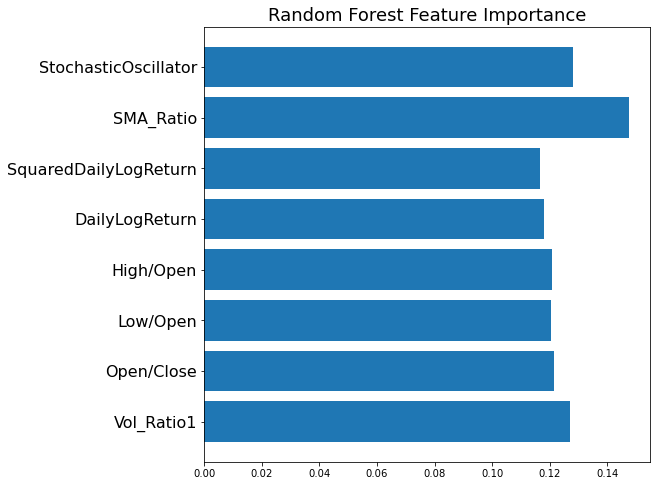

In [31]:
fig, ax = plt.subplots(figsize = (8,8))
ax.barh(np.arange(0, len(feature_names_list)), importance['Importance'])
ax.set_yticklabels(feature_names_list, fontdict = {'size': 16})
ax.set_yticks(np.arange(0, len(feature_names_list)))
ax.set_title('Random Forest Feature Importance', fontdict = {'size': 18})
plt.show()

### Hyperparameter Tuning: In Progress: ETA:TBD

In [136]:
from sklearn.model_selection import GridSearchCV

In [138]:
model_params = {'n_estimators': [50, 150, 250],
                'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
                'min_samples_split': [2, 4, 6]}

In [139]:
rf_model = RandomForestClassifier(random_state = 1)

In [140]:
clf = GridSearchCV(rf_model, model_params, cv = 5)

In [141]:
start_time = time.time()
model = clf.fit(df[X_features], df[y_feature])

print(time.time() - start_time)

In [142]:
from pprint import pprint

In [143]:
pprint(model.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 0.5,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


In [144]:
performance(model, X_train, X_test, y_train, y_test)

Model train accuracy: 0.998
Model test accuracy: 0.692
Confusion Matrix:
[[307  58]
 [131 117]]

Accuracy score:  0.6916802610114192
 
Recall score:  0.4717741935483871
 
Precision score:  0.6685714285714286


### 

In [128]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
num_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [129]:
random_grid = {'n_estimators': n_estimators,
               'max_features': num_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [133]:
rf = RandomForestClassifier()

In [134]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose = 2,
                              random_state = 42, n_jobs = -1)

In [135]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

### Save Model to file

In [38]:
import os

In [39]:
os.getcwd()

'C:\\Users\\Eddie\\Stock_market'

In [40]:
os.chdir('C:\\Users\\Eddie\\Documents\\Stock_Market')

In [41]:
import pickle

In [42]:
filename = 'RandomForest1.sav'

In [43]:
pickle.dump(model2, open(filename, 'wb'))

In [188]:
list(df[X_features].columns)

['Vol_Ratio1',
 'Open/Close',
 'Low/Open',
 'High/Open',
 'DailyLogReturn',
 'SquaredDailyLogReturn',
 'SMA_Ratio',
 'StochasticOscillator']

In [189]:
X_test.shape

(613, 8)

In [190]:
type(X_test)

pandas.core.frame.DataFrame